# 2.8 Robust Tail Optimization

Hyperparameter optimization using tail-aware metrics that are robust to outliers.

**Selection Metrics:**
1. **Winsorized Sharpe** - Clip returns at 5th/95th percentile before computing Sharpe
2. **CVaR (5%)** - Average return in worst 5% of days (Expected Shortfall)
3. **Sortino Ratio** - Mean / downside std (only penalizes negative volatility)

**Why these metrics?**
- IC Sharpe ignores actual return magnitudes
- Raw Short Sharpe is dominated by single outliers (30% SL cliff)
- These metrics balance tail-awareness with robustness

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from dataclasses import dataclass
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

Using device: cpu


In [2]:
@dataclass
class ModelConfig:
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    fund_hidden: int = 64
    price_hidden: int = 32
    news_hidden: int = 128
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    fundamental_dropout: float = 0.6
    price_dropout: float = 0.3
    news_dropout: float = 0.1
    news_alpha: float = 0.8
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 1e-3
    label_smoothing: float = 0.1
    n_epochs: int = 15

## 1. Load Data

In [3]:
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])
df["simple_return"] = np.exp(df["target_return"]) - 1

# Clip for training only
CLIP_LIMIT = 1.0
df["simple_return_clipped"] = df["simple_return"].clip(-CLIP_LIMIT, CLIP_LIMIT)

print(f"Dataset: {len(df):,} rows")

Dataset: 2,092,929 rows


In [4]:
price_feat_cols = [
    "overnight_gap_z", "intraday_ret_z",
    "ret_1d_z", "ret_2d_z", "ret_3d_z", "ret_5d_z",
    "vol_5d_z", "dist_from_high_5d_z", "dist_from_low_5d_z"
]
fund_feat_cols = [c for c in df.columns if c.endswith("_z") and c not in price_feat_cols and c != "news_count_z"]
emb_cols = [c for c in df.columns if c.startswith("emb_")]

print(f"Price: {len(price_feat_cols)}, Fund: {len(fund_feat_cols)}, Emb: {len(emb_cols)}")

Price: 9, Fund: 19, Emb: 768


In [5]:
# Time split
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
train_end = int(n_dates * 0.7)
val_end = int(n_dates * 0.8)

train_dates = set(dates[:train_end])
val_dates = set(dates[train_end:val_end])
test_dates = set(dates[val_end:])

train_df = df[df["feature_date"].isin(train_dates)].copy()
val_df = df[df["feature_date"].isin(val_dates)].copy()
test_df = df[df["feature_date"].isin(test_dates)].copy()

def filter_news_only(df_in):
    has_news = (df_in[emb_cols].abs().sum(axis=1) > 0)
    return df_in[has_news].copy()

val_df_news = filter_news_only(val_df)
test_df_news = filter_news_only(test_df)

print(f"Train: {len(train_df):,}, Val: {len(val_df_news):,}, Test: {len(test_df_news):,}")

Train: 1,418,494, Val: 58,882, Test: 128,502


## 2. Dataset and Model

In [6]:
class SinglePairDataset(Dataset):
    def __init__(self, df, price_cols, fund_cols, emb_cols, verbose=True):
        has_news = (df[emb_cols].abs().sum(axis=1) > 0)
        df_news = df[has_news].copy().reset_index(drop=True)
        if verbose:
            print(f"Filtered to news-only: {len(df_news):,} rows")

        self.df = df_news
        self.price_cols = price_cols
        self.fund_cols = fund_cols
        self.emb_cols = emb_cols

        self.date_groups = {}
        for date, group in self.df.groupby("feature_date"):
            indices = group.index.tolist()
            if len(indices) >= 2:
                self.date_groups[date] = indices
        self.dates = list(self.date_groups.keys())

        self.price_arr = self.df[price_cols].values.astype(np.float32)
        self.fund_arr = self.df[fund_cols].values.astype(np.float32)
        self.emb_arr = self.df[emb_cols].values.astype(np.float32)
        self.target_arr = self.df["simple_return_clipped"].values.astype(np.float32)

        self.pairs = []
        self._generate_pairs(verbose=verbose)

    def _generate_pairs(self, verbose=False):
        pairs = []
        for date in self.dates:
            indices = list(self.date_groups[date])
            np.random.shuffle(indices)
            for i in range(0, len(indices) - 1, 2):
                pairs.append((indices[i], indices[i + 1]))
        self.pairs = pairs
        if verbose:
            print(f"Generated {len(self.pairs):,} pairs")

    def resample_pairs(self):
        self._generate_pairs()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        price_i, price_j = self.price_arr[i], self.price_arr[j]
        fund_i, fund_j = self.fund_arr[i], self.fund_arr[j]
        emb_i, emb_j = self.emb_arr[i], self.emb_arr[j]
        label = 1.0 if self.target_arr[i] > self.target_arr[j] else 0.0

        if np.random.random() < 0.5:
            price_i, price_j = price_j, price_i
            fund_i, fund_j = fund_j, fund_i
            emb_i, emb_j = emb_j, emb_i
            label = 1.0 - label

        return {
            "price_i": torch.tensor(price_i), "price_j": torch.tensor(price_j),
            "fund_i": torch.tensor(fund_i), "fund_j": torch.tensor(fund_j),
            "emb_i": torch.tensor(emb_i), "emb_j": torch.tensor(emb_j),
            "label": torch.tensor(label),
        }

In [7]:
class MultiBranchRanker(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, config.fund_hidden),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(config.fund_hidden, config.fundamental_latent),
            nn.ReLU(),
        )
        
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, config.price_hidden),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(config.price_hidden, config.price_latent),
            nn.ReLU(),
        )
        
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, config.news_hidden),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(config.news_hidden, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)
    
    def forward_pair(self, price_i, fund_i, emb_i, price_j, fund_j, emb_j):
        score_i = self.forward(price_i, fund_i, emb_i)
        score_j = self.forward(price_j, fund_j, emb_j)
        return torch.sigmoid(score_i - score_j)

## 3. Robust Evaluation Metrics

In [8]:
def compute_robust_metrics(daily_returns, annualize=True):
    """Compute multiple robust metrics from daily strategy returns.
    
    Args:
        daily_returns: array of daily returns
        annualize: whether to annualize Sharpe/Sortino
    
    Returns:
        dict with various metrics
    """
    returns = np.array(daily_returns)
    n_days = len(returns)
    
    if n_days < 10:
        return {k: 0.0 for k in ['sharpe', 'winsorized_sharpe', 'sortino', 'cvar_5', 'cvar_10', 'mean_return', 'std_return']}
    
    factor = np.sqrt(252) if annualize else 1.0
    
    # 1. Standard Sharpe
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    sharpe = (mean_ret / std_ret * factor) if std_ret > 0 else 0.0
    
    # 2. Winsorized Sharpe (clip at 5th/95th percentile)
    p5, p95 = np.percentile(returns, [5, 95])
    winsorized = np.clip(returns, p5, p95)
    win_mean = np.mean(winsorized)
    win_std = np.std(winsorized)
    winsorized_sharpe = (win_mean / win_std * factor) if win_std > 0 else 0.0
    
    # 3. Sortino Ratio (downside deviation only)
    downside_returns = returns[returns < 0]
    if len(downside_returns) > 0:
        downside_std = np.std(downside_returns)
        sortino = (mean_ret / downside_std * factor) if downside_std > 0 else 0.0
    else:
        sortino = float('inf') if mean_ret > 0 else 0.0
    
    # 4. CVaR (Expected Shortfall) at 5% - average of worst 5% of days
    n_tail = max(1, int(n_days * 0.05))
    sorted_returns = np.sort(returns)
    cvar_5 = np.mean(sorted_returns[:n_tail])  # Average of worst 5%
    
    # 5. CVaR at 10%
    n_tail_10 = max(1, int(n_days * 0.10))
    cvar_10 = np.mean(sorted_returns[:n_tail_10])
    
    return {
        'sharpe': sharpe,
        'winsorized_sharpe': winsorized_sharpe,
        'sortino': sortino,
        'cvar_5': cvar_5,  # More negative = worse
        'cvar_10': cvar_10,
        'mean_return': mean_ret,
        'std_return': std_ret,
    }

In [9]:
@torch.no_grad()
def get_scores(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    model.eval()
    price_arr = torch.tensor(df[price_cols].values.astype(np.float32))
    fund_arr = torch.tensor(df[fund_cols].values.astype(np.float32))
    emb_arr = torch.tensor(df[emb_cols].values.astype(np.float32))
    
    scores = []
    for i in range(0, len(df), batch_size):
        price = price_arr[i:i+batch_size].to(device)
        fund = fund_arr[i:i+batch_size].to(device)
        emb = emb_arr[i:i+batch_size].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    return np.concatenate(scores)


def evaluate_model(model, df, price_cols, fund_cols, emb_cols, device, k=5):
    """Compute all metrics including robust tail metrics."""
    df_eval = df.copy()
    df_eval["score"] = get_scores(model, df_eval, price_cols, fund_cols, emb_cols, device)
    
    # IC Sharpe (rank-based)
    ics = []
    for date, group in df_eval.groupby("feature_date"):
        if len(group) < 10:
            continue
        ic, _ = spearmanr(group["score"], group["simple_return"])
        if not np.isnan(ic):
            ics.append(ic)
    
    mean_ic = np.mean(ics) if ics else 0
    ic_std = np.std(ics) if ics else 1
    ic_sharpe = mean_ic / ic_std * np.sqrt(252) if ic_std > 0 else 0
    
    # Daily short strategy returns (unclipped for realistic eval)
    daily_returns = []
    for date, group in df_eval.groupby("feature_date"):
        if len(group) < 10:
            continue
        bottom = group.nsmallest(k, "score")
        short_ret = -bottom["simple_return"].mean()  # Short = negative of return
        daily_returns.append(short_ret)
    
    # Compute robust metrics
    robust = compute_robust_metrics(daily_returns)
    
    return {
        'ic_sharpe': ic_sharpe,
        'mean_ic': mean_ic,
        **robust,
    }

In [10]:
# Test robust metrics on sample data
np.random.seed(42)
sample_returns = np.random.normal(0.001, 0.02, 252)  # ~1yr of daily returns
# Add a few outliers
sample_returns[10] = -0.50  # 50% loss day
sample_returns[100] = 0.30  # 30% gain day

metrics = compute_robust_metrics(sample_returns)
print("Sample metrics with outliers:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

Sample metrics with outliers:
  sharpe: 0.1042
  winsorized_sharpe: 0.7324
  sortino: 0.0943
  cvar_5: -0.0757
  cvar_10: -0.0503
  mean_return: 0.0003
  std_return: 0.0415


## 4. Training

In [11]:
def pairwise_ranking_loss(pred_prob, label, smoothing=0.1):
    smoothed_label = label * (1 - smoothing) + 0.5 * smoothing
    return F.binary_cross_entropy(pred_prob, smoothed_label)


def train_epoch(model, loader, optimizer, device, label_smoothing=0.1):
    model.train()
    total_loss = 0
    total_samples = 0
    
    for batch in loader:
        price_i = batch["price_i"].to(device)
        price_j = batch["price_j"].to(device)
        fund_i = batch["fund_i"].to(device)
        fund_j = batch["fund_j"].to(device)
        emb_i = batch["emb_i"].to(device)
        emb_j = batch["emb_j"].to(device)
        label = batch["label"].to(device)
        
        optimizer.zero_grad()
        pred_prob = model.forward_pair(price_i, fund_i, emb_i, price_j, fund_j, emb_j)
        loss = pairwise_ranking_loss(pred_prob, label, smoothing=label_smoothing)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(label)
        total_samples += len(label)
    
    return total_loss / total_samples


def train_and_evaluate(config, train_dataset, val_df_news, selection_metric='winsorized_sharpe', n_epochs=15, verbose=False):
    """Train model, select best checkpoint by specified metric."""
    model = MultiBranchRanker(config).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=config.learning_rate, 
        weight_decay=config.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    
    best_metric = -float('inf')
    best_state = None
    
    for epoch in range(n_epochs):
        train_dataset.resample_pairs()
        train_loss = train_epoch(model, train_loader, optimizer, device, config.label_smoothing)
        scheduler.step()
        
        if (epoch + 1) % 5 == 0 or epoch == n_epochs - 1:
            metrics = evaluate_model(model, val_df_news, price_feat_cols, fund_feat_cols, emb_cols, device)
            
            # For CVaR, higher (less negative) is better
            current = metrics[selection_metric]
            if current > best_metric:
                best_metric = current
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            
            if verbose:
                print(f"  Epoch {epoch+1}: {selection_metric}={current:.3f}")
    
    model.load_state_dict(best_state)
    final_metrics = evaluate_model(model, val_df_news, price_feat_cols, fund_feat_cols, emb_cols, device)
    
    return final_metrics, model

In [12]:
# Create training dataset
train_dataset = SinglePairDataset(train_df, price_feat_cols, fund_feat_cols, emb_cols, verbose=True)

Filtered to news-only: 339,872 rows
Generated 169,737 pairs


## 5. Search Space

In [13]:
SEARCH_SPACE = {
    # Architecture
    "latent_scale": [0.5, 1.0, 2.0],
    "hidden_scale": [0.5, 1.0, 1.5],
    "news_alpha": [0.6, 0.8, 1.0],
    # Training
    "learning_rate": [5e-4, 1e-3, 2e-3],
    "weight_decay": [1e-4, 1e-3, 1e-2],
    "label_smoothing": [0.05, 0.1, 0.15],
    # Dropout
    "fund_dropout": [0.4, 0.5, 0.6, 0.7],
    "price_dropout": [0.2, 0.3, 0.4],
    "news_dropout": [0.1, 0.2, 0.3],
}

# Selection metrics to test
SELECTION_METRICS = ['winsorized_sharpe', 'cvar_5', 'sortino', 'ic_sharpe']

n_arch = len(SEARCH_SPACE["latent_scale"]) * len(SEARCH_SPACE["hidden_scale"]) * len(SEARCH_SPACE["news_alpha"])
print(f"Architecture configs: {n_arch}")

Architecture configs: 27


## 6. Compare Selection Metrics

Run architecture search with each selection metric to see which finds best configs.

In [14]:
print("COMPARING SELECTION METRICS")
print("=" * 70)
print("Running architecture search with each metric...")

arch_configs = list(product(
    SEARCH_SPACE["latent_scale"],
    SEARCH_SPACE["hidden_scale"],
    SEARCH_SPACE["news_alpha"],
))

# Store results for each selection metric
metric_results = {m: [] for m in SELECTION_METRICS}

for i, (latent_scale, hidden_scale, news_alpha) in enumerate(arch_configs):
    config = ModelConfig(
        n_fundamental_features=len(fund_feat_cols),
        n_price_features=len(price_feat_cols),
        n_embedding_dim=len(emb_cols),
        fund_hidden=int(64 * hidden_scale),
        price_hidden=int(32 * hidden_scale),
        news_hidden=int(128 * hidden_scale),
        fundamental_latent=int(32 * latent_scale),
        price_latent=int(16 * latent_scale),
        news_latent=int(32 * latent_scale),
        news_alpha=news_alpha,
    )
    
    # Train with winsorized_sharpe (our main metric)
    start = datetime.now()
    metrics, _ = train_and_evaluate(config, train_dataset, val_df_news, 
                                     selection_metric='winsorized_sharpe', n_epochs=15)
    elapsed = (datetime.now() - start).total_seconds()
    
    result = {
        "latent_scale": latent_scale,
        "hidden_scale": hidden_scale,
        "news_alpha": news_alpha,
        **metrics,
    }
    
    # Store for all metrics
    for m in SELECTION_METRICS:
        metric_results[m].append(result)
    
    print(f"[{i+1:2d}/{len(arch_configs)}] l={latent_scale:.1f} h={hidden_scale:.1f} a={news_alpha:.1f} | "
          f"WinSharpe={metrics['winsorized_sharpe']:.2f} CVaR5={metrics['cvar_5']:.3f} "
          f"Sortino={metrics['sortino']:.2f} IC={metrics['ic_sharpe']:.2f} | {elapsed:.0f}s")

COMPARING SELECTION METRICS
Running architecture search with each metric...
[ 1/27] l=0.5 h=0.5 a=0.6 | WinSharpe=2.46 CVaR5=-0.477 Sortino=0.13 IC=3.83 | 136s
[ 2/27] l=0.5 h=0.5 a=0.8 | WinSharpe=1.70 CVaR5=-0.462 Sortino=-0.15 IC=3.99 | 131s
[ 3/27] l=0.5 h=0.5 a=1.0 | WinSharpe=1.40 CVaR5=-0.502 Sortino=-0.37 IC=3.99 | 133s
[ 4/27] l=0.5 h=1.0 a=0.6 | WinSharpe=2.15 CVaR5=-0.481 Sortino=0.01 IC=3.86 | 143s
[ 5/27] l=0.5 h=1.0 a=0.8 | WinSharpe=2.55 CVaR5=-0.467 Sortino=0.01 IC=4.93 | 149s
[ 6/27] l=0.5 h=1.0 a=1.0 | WinSharpe=2.82 CVaR5=-0.445 Sortino=0.16 IC=4.80 | 143s
[ 7/27] l=0.5 h=1.5 a=0.6 | WinSharpe=2.24 CVaR5=-0.502 Sortino=0.13 IC=4.29 | 152s
[ 8/27] l=0.5 h=1.5 a=0.8 | WinSharpe=2.76 CVaR5=-0.462 Sortino=0.16 IC=3.31 | 155s
[ 9/27] l=0.5 h=1.5 a=1.0 | WinSharpe=1.65 CVaR5=-0.496 Sortino=-0.14 IC=5.28 | 152s
[10/27] l=1.0 h=0.5 a=0.6 | WinSharpe=2.05 CVaR5=-0.473 Sortino=0.14 IC=3.44 | 134s
[11/27] l=1.0 h=0.5 a=0.8 | WinSharpe=1.55 CVaR5=-0.499 Sortino=-0.26 IC=3.89 | 1

In [ ]:
# Compare best configs found by each metric
print("\nBEST CONFIGS BY EACH SELECTION METRIC:")
print("=" * 70)

best_by_metric = {}
for metric in SELECTION_METRICS:
    df_results = pd.DataFrame(metric_results[metric])
    
    # For CVaR, higher (less negative) is better
    best_idx = df_results[metric].idxmax()
    best = df_results.loc[best_idx]
    best_by_metric[metric] = best
    
    print(f"\n{metric}:")
    print(f"  Best config: latent={best['latent_scale']}, hidden={best['hidden_scale']}, alpha={best['news_alpha']}")
    print(f"  Metrics: WinSharpe={best['winsorized_sharpe']:.2f}, CVaR5={best['cvar_5']:.3f}, "
          f"Sortino={best['sortino']:.2f}, IC={best['ic_sharpe']:.2f}")


BEST CONFIGS BY EACH SELECTION METRIC:

winsorized_sharpe:
  Best config: latent=0.5, hidden=1.0, alpha=1.0
  Metrics: WinSharpe=2.82, CVaR5=-0.445, Sortino=0.16, IC=4.80

cvar_5:
  Best config: latent=1.0, hidden=1.5, alpha=0.8
  Metrics: WinSharpe=2.31, CVaR5=-0.429, Sortino=-0.03, IC=3.70

sortino:
  Best config: latent=2.0, hidden=0.5, alpha=0.6
  Metrics: WinSharpe=2.69, CVaR5=-0.502, Sortino=0.26, IC=3.97

ic_sharpe:
  Best config: latent=0.5, hidden=1.5, alpha=1.0
  Metrics: WinSharpe=1.65, CVaR5=-0.496, Sortino=-0.14, IC=5.28


In [ ]:
# Correlation between metrics
df_all = pd.DataFrame(metric_results['winsorized_sharpe'])
corr_cols = ['ic_sharpe', 'sharpe', 'winsorized_sharpe', 'sortino', 'cvar_5', 'cvar_10']

print("\nMETRIC CORRELATIONS:")
print(df_all[corr_cols].corr().round(2))


METRIC CORRELATIONS:
                   ic_sharpe  sharpe  winsorized_sharpe  sortino  cvar_5  \
ic_sharpe               1.00    0.03               0.10     0.04    0.16   
sharpe                  0.03    1.00               0.87     1.00    0.30   
winsorized_sharpe       0.10    0.87               1.00     0.87    0.40   
sortino                 0.04    1.00               0.87     1.00    0.31   
cvar_5                  0.16    0.30               0.40     0.31    1.00   
cvar_10                 0.13    0.28               0.50     0.28    0.92   

                   cvar_10  
ic_sharpe             0.13  
sharpe                0.28  
winsorized_sharpe     0.50  
sortino               0.28  
cvar_5                0.92  
cvar_10               1.00  


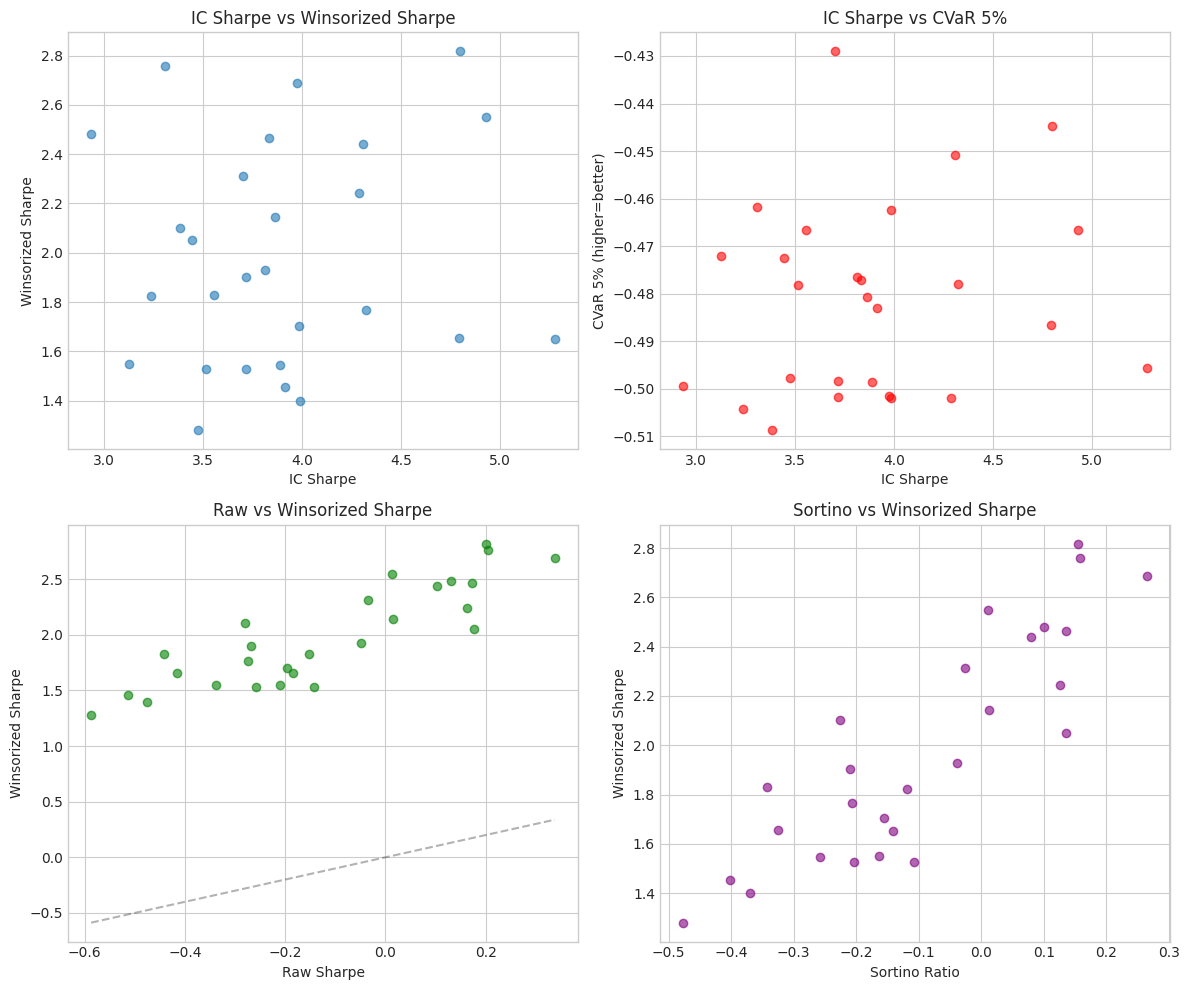

In [ ]:
# Visualize metric relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# IC Sharpe vs Winsorized Sharpe
ax = axes[0, 0]
ax.scatter(df_all['ic_sharpe'], df_all['winsorized_sharpe'], alpha=0.6)
ax.set_xlabel('IC Sharpe')
ax.set_ylabel('Winsorized Sharpe')
ax.set_title('IC Sharpe vs Winsorized Sharpe')

# IC Sharpe vs CVaR
ax = axes[0, 1]
ax.scatter(df_all['ic_sharpe'], df_all['cvar_5'], alpha=0.6, c='red')
ax.set_xlabel('IC Sharpe')
ax.set_ylabel('CVaR 5% (higher=better)')
ax.set_title('IC Sharpe vs CVaR 5%')

# Winsorized vs Raw Sharpe
ax = axes[1, 0]
ax.scatter(df_all['sharpe'], df_all['winsorized_sharpe'], alpha=0.6, c='green')
ax.plot([df_all['sharpe'].min(), df_all['sharpe'].max()], 
        [df_all['sharpe'].min(), df_all['sharpe'].max()], 'k--', alpha=0.3)
ax.set_xlabel('Raw Sharpe')
ax.set_ylabel('Winsorized Sharpe')
ax.set_title('Raw vs Winsorized Sharpe')

# Sortino vs Winsorized
ax = axes[1, 1]
ax.scatter(df_all['sortino'], df_all['winsorized_sharpe'], alpha=0.6, c='purple')
ax.set_xlabel('Sortino Ratio')
ax.set_ylabel('Winsorized Sharpe')
ax.set_title('Sortino vs Winsorized Sharpe')

plt.tight_layout()
plt.show()

## 7. Full Optimization with Best Metric

Use Winsorized Sharpe for full staged optimization.

In [ ]:
SELECTION_METRIC = 'winsorized_sharpe'  # Change this to test others

print(f"\nFULL OPTIMIZATION WITH {SELECTION_METRIC.upper()}")
print("=" * 70)

# Best architecture from comparison
best_arch = best_by_metric[SELECTION_METRIC]
best_latent = best_arch['latent_scale']
best_hidden = best_arch['hidden_scale']
best_alpha = best_arch['news_alpha']

print(f"Best architecture: latent={best_latent}, hidden={best_hidden}, alpha={best_alpha}")


FULL OPTIMIZATION WITH WINSORIZED_SHARPE
Best architecture: latent=0.5, hidden=1.0, alpha=1.0


In [ ]:
# Stage 2: Training hyperparameters
print("\nSTAGE 2: TRAINING HYPERPARAMETERS")
print("-" * 50)

train_configs = list(product(
    SEARCH_SPACE["learning_rate"],
    SEARCH_SPACE["weight_decay"],
    SEARCH_SPACE["label_smoothing"],
))

train_results = []
best_train_metric = -float('inf')
best_train = None

for i, (lr, wd, smoothing) in enumerate(train_configs):
    config = ModelConfig(
        n_fundamental_features=len(fund_feat_cols),
        n_price_features=len(price_feat_cols),
        n_embedding_dim=len(emb_cols),
        fund_hidden=int(64 * best_hidden),
        price_hidden=int(32 * best_hidden),
        news_hidden=int(128 * best_hidden),
        fundamental_latent=int(32 * best_latent),
        price_latent=int(16 * best_latent),
        news_latent=int(32 * best_latent),
        news_alpha=best_alpha,
        learning_rate=lr,
        weight_decay=wd,
        label_smoothing=smoothing,
    )
    
    metrics, _ = train_and_evaluate(config, train_dataset, val_df_news, 
                                     selection_metric=SELECTION_METRIC, n_epochs=15)
    
    train_results.append({"lr": lr, "wd": wd, "smooth": smoothing, **metrics})
    
    if metrics[SELECTION_METRIC] > best_train_metric:
        best_train_metric = metrics[SELECTION_METRIC]
        best_train = (lr, wd, smoothing)
    
    print(f"[{i+1:2d}/{len(train_configs)}] lr={lr:.0e} wd={wd:.0e} s={smoothing:.2f} | "
          f"{SELECTION_METRIC}={metrics[SELECTION_METRIC]:.3f}")

best_lr, best_wd, best_smooth = best_train
print(f"\nBest: lr={best_lr:.0e}, wd={best_wd:.0e}, smooth={best_smooth}")


STAGE 2: TRAINING HYPERPARAMETERS
--------------------------------------------------
[ 1/27] lr=5e-04 wd=1e-04 s=0.05 | winsorized_sharpe=1.349
[ 2/27] lr=5e-04 wd=1e-04 s=0.10 | winsorized_sharpe=3.163
[ 3/27] lr=5e-04 wd=1e-04 s=0.15 | winsorized_sharpe=1.752
[ 4/27] lr=5e-04 wd=1e-03 s=0.05 | winsorized_sharpe=2.246
[ 5/27] lr=5e-04 wd=1e-03 s=0.10 | winsorized_sharpe=2.128
[ 6/27] lr=5e-04 wd=1e-03 s=0.15 | winsorized_sharpe=1.798


In [ ]:
# Stage 3: Dropout
print("\nSTAGE 3: DROPOUT")
print("-" * 50)

dropout_configs = list(product(
    SEARCH_SPACE["fund_dropout"],
    SEARCH_SPACE["price_dropout"],
    SEARCH_SPACE["news_dropout"],
))

dropout_results = []
best_dropout_metric = -float('inf')
best_dropout = None
best_model = None

for i, (fund_do, price_do, news_do) in enumerate(dropout_configs):
    config = ModelConfig(
        n_fundamental_features=len(fund_feat_cols),
        n_price_features=len(price_feat_cols),
        n_embedding_dim=len(emb_cols),
        fund_hidden=int(64 * best_hidden),
        price_hidden=int(32 * best_hidden),
        news_hidden=int(128 * best_hidden),
        fundamental_latent=int(32 * best_latent),
        price_latent=int(16 * best_latent),
        news_latent=int(32 * best_latent),
        news_alpha=best_alpha,
        fundamental_dropout=fund_do,
        price_dropout=price_do,
        news_dropout=news_do,
        learning_rate=best_lr,
        weight_decay=best_wd,
        label_smoothing=best_smooth,
    )
    
    metrics, model = train_and_evaluate(config, train_dataset, val_df_news, 
                                         selection_metric=SELECTION_METRIC, n_epochs=15)
    
    dropout_results.append({"fund": fund_do, "price": price_do, "news": news_do, **metrics})
    
    if metrics[SELECTION_METRIC] > best_dropout_metric:
        best_dropout_metric = metrics[SELECTION_METRIC]
        best_dropout = (fund_do, price_do, news_do)
        best_model = model
    
    print(f"[{i+1:2d}/{len(dropout_configs)}] f={fund_do:.1f} p={price_do:.1f} n={news_do:.1f} | "
          f"{SELECTION_METRIC}={metrics[SELECTION_METRIC]:.3f}")

best_fund_do, best_price_do, best_news_do = best_dropout
print(f"\nBest: fund={best_fund_do}, price={best_price_do}, news={best_news_do}")

## 8. Final Model

In [ ]:
print("\nTRAINING FINAL MODEL (25 epochs)")
print("=" * 70)

final_config = ModelConfig(
    n_fundamental_features=len(fund_feat_cols),
    n_price_features=len(price_feat_cols),
    n_embedding_dim=len(emb_cols),
    fund_hidden=int(64 * best_hidden),
    price_hidden=int(32 * best_hidden),
    news_hidden=int(128 * best_hidden),
    fundamental_latent=int(32 * best_latent),
    price_latent=int(16 * best_latent),
    news_latent=int(32 * best_latent),
    news_alpha=best_alpha,
    fundamental_dropout=best_fund_do,
    price_dropout=best_price_do,
    news_dropout=best_news_do,
    learning_rate=best_lr,
    weight_decay=best_wd,
    label_smoothing=best_smooth,
    n_epochs=25,
)

print(f"Config: hidden=({final_config.fund_hidden},{final_config.price_hidden},{final_config.news_hidden})")
print(f"        latent=({final_config.fundamental_latent},{final_config.price_latent},{final_config.news_latent})")
print(f"        dropout=({final_config.fundamental_dropout},{final_config.price_dropout},{final_config.news_dropout})")
print(f"        lr={final_config.learning_rate:.0e}, wd={final_config.weight_decay:.0e}")

final_metrics, final_model = train_and_evaluate(
    final_config, train_dataset, val_df_news, 
    selection_metric=SELECTION_METRIC, n_epochs=25, verbose=True
)

In [ ]:
# Test set evaluation
test_metrics = evaluate_model(final_model, test_df_news, price_feat_cols, fund_feat_cols, emb_cols, device)

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"IC Sharpe:         {test_metrics['ic_sharpe']:.2f}")
print(f"Raw Sharpe:        {test_metrics['sharpe']:.2f}")
print(f"Winsorized Sharpe: {test_metrics['winsorized_sharpe']:.2f}")
print(f"Sortino:           {test_metrics['sortino']:.2f}")
print(f"CVaR 5%:           {test_metrics['cvar_5']:.4f}")
print(f"CVaR 10%:          {test_metrics['cvar_10']:.4f}")
print(f"Mean Daily Return: {test_metrics['mean_return']:.4f}")

## 9. Save Results

In [ ]:
# Save results
pd.DataFrame(metric_results['winsorized_sharpe']).to_parquet("data/robust_arch_results2.pqt")
pd.DataFrame(train_results).to_parquet("data/robust_train_results2.pqt")
pd.DataFrame(dropout_results).to_parquet("data/robust_dropout_results2.pqt")

torch.save({
    "model_state_dict": final_model.state_dict(),
    "config": final_config,
    "price_cols": price_feat_cols,
    "fund_cols": fund_feat_cols,
    "emb_cols": emb_cols,
    "selection_metric": SELECTION_METRIC,
    "test_metrics": test_metrics,
}, "data/model_robust_optimized2.pt")

print("Saved to data/model_robust_optimized2.pt")

In [24]:
# print("\n" + "=" * 60)
# print("SUMMARY")
# print("=" * 60)
# print(f"Selection metric: {SELECTION_METRIC}")
# print(f"\nBest config:")
# print(f"  Architecture: latent={best_latent}, hidden={best_hidden}, alpha={best_alpha}")
# print(f"  Training: lr={best_lr:.0e}, wd={best_wd:.0e}, smooth={best_smooth}")
# print(f"  Dropout: fund={best_fund_do}, price={best_price_do}, news={best_news_do}")
# print(f"\nTest performance:")
# print(f"  Winsorized Sharpe: {test_metrics['winsorized_sharpe']:.2f}")
# print(f"  CVaR 5%: {test_metrics['cvar_5']:.4f}")
# print(f"  Sortino: {test_metrics['sortino']:.2f}")


SUMMARY
Selection metric: winsorized_sharpe

Best config:
  Architecture: latent=0.5, hidden=1.5, alpha=1.0
  Training: lr=5e-04, wd=1e-04, smooth=0.15
  Dropout: fund=0.6, price=0.3, news=0.1

Test performance:
  Winsorized Sharpe: 3.19
  CVaR 5%: -0.3300
  Sortino: 1.18


In [ ]:
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Selection metric: {SELECTION_METRIC}")
print(f"\nBest config:")
print(f"  Architecture: latent={best_latent}, hidden={best_hidden}, alpha={best_alpha}")
print(f"  Training: lr={best_lr:.0e}, wd={best_wd:.0e}, smooth={best_smooth}")
print(f"  Dropout: fund={best_fund_do}, price={best_price_do}, news={best_news_do}")
print(f"\nTest performance:")
print(f"  Winsorized Sharpe: {test_metrics['winsorized_sharpe']:.2f}")
print(f"  CVaR 5%: {test_metrics['cvar_5']:.4f}")
print(f"  Sortino: {test_metrics['sortino']:.2f}")